# Face Swapping using Dlib + OpenCV

In [1]:
import cv2, dlib
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# dlib dependency for facial landmark predictor
PREDICTOR_PATH = "shape_predictor_68_face_landmarks.dat"
SCALE_FACTOR = 1
# 
FEATHER_AMOUNT = 11
FACE_POINTS = list(range(17, 68))
MOUTH_POINTS = list(range(48, 61))
RIGHT_BROW_POINTS = list(range(17, 22))
LEFT_BROW_POINTS = list(range(22, 27))
RIGHT_EYE_POINTS = list(range(36, 42))
LEFT_EYE_POINTS = list(range(42, 48))
NOSE_POINTS = list(range(27, 35))
JAW_POINTS = list(range(0, 17))
COLOUR_CORRECT_BLUR_FRAC = 0.6
ALIGN_POINTS = (LEFT_BROW_POINTS + RIGHT_EYE_POINTS + LEFT_EYE_POINTS +
                RIGHT_BROW_POINTS + NOSE_POINTS + MOUTH_POINTS)
OVERLAY_POINTS = [
    LEFT_EYE_POINTS + RIGHT_EYE_POINTS + LEFT_BROW_POINTS + RIGHT_BROW_POINTS,
    NOSE_POINTS + MOUTH_POINTS,
]

# create a dlib face detector and shape predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)

# Read Landmarks

1. Runs the dlib frontal face detector firs
2. Runs the dlib shape predictor
3. Returns the scaled image and the landmarks

In [3]:
def read_landmarks(im):
    im = cv2.resize(im, (im.shape[1] * SCALE_FACTOR,
                         im.shape[0] * SCALE_FACTOR))

    rects = detector(im, 1)

    if len(rects) > 1:
            raise Exception
    if len(rects) == 0:
            raise Exception

    ps = predictor(im, rects[0])
    s = np.matrix([[p.x, p.y] for p in ps.parts()])

    return im, s

# Transformation from points

Creates an affine transformation matrix. Solved using ordinary procrustus analysis.
https://en.wikipedia.org/wiki/Procrustes_analysis#Ordinary_Procrustes_analysis

1. Subtract the centroids
2. Divide each point set by its standard deviation
3. Calculate rotation using SVD https://en.wikipedia.org/wiki/Orthogonal_Procrustes_problem
4. Return the transformation matrix

In [4]:
def transformation_from_points(points1, points2):
    points1 = points1.astype(np.float64)
    points2 = points2.astype(np.float64)

    c1 = np.mean(points1, axis=0)
    c2 = np.mean(points2, axis=0)
    points1 -= c1
    points2 -= c2

    s1 = np.std(points1)
    s2 = np.std(points2)
    points1 /= s1
    points2 /= s2
    t = points1.T
    mul = t * points2
    U, S, Vt = np.linalg.svd(mul)
    R = (U * Vt).T

    return np.vstack([np.hstack(((s2 / s1) * R,
                                       c2.T - (s2 / s1) * R * c1.T)),
                      np.matrix([0., 0., 1.])])

# Get face mask

Creates a mask image out of our image using the landmarks detected by dlib.
1. Create a new numpy array for our new mask image using the (rows, cols) shape from the image
2. For each point group (eyes + brows, nose + mouth) we call the draw_convex_hull function
3. Blur the resulting image and create a binary mask from the values greater than 1 (a)
4. Set all true values of this mask to 1 - increasing the 
5. Blue the final mask

In [5]:
def get_face_mask(im, landmarks):
    s = im.shape[:2]
    im = np.zeros(s, dtype=np.float64)

    for group in OVERLAY_POINTS:
        to_draw = landmarks[group]

        draw_convex_hull(im, to_draw, color=1)

    im = np.array([im, im, im]).transpose((1, 2, 0))

    a = cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0) > 0

    im = (a) * 1.0
    im = cv2.GaussianBlur(im, (FEATHER_AMOUNT, FEATHER_AMOUNT), 0)

    return im

def draw_convex_hull(im, points, color):
    points = cv2.convexHull(points)
    cv2.fillConvexPoly(im, points, color=color)

# Warp IM

Takes an image and runs the openCV warpAffine function on it, returning a new warped image

In [6]:
def warp_im(im, M, dshape):
    output_im = np.zeros(dshape, dtype=im.dtype)
    cv2.warpAffine(im,
                   M[:2],
                   (dshape[1], dshape[0]),
                   dst=output_im,
                   borderMode=cv2.BORDER_TRANSPARENT,
                   flags=cv2.WARP_INVERSE_MAP)
    return output_im

# Correct Colors

1. Select a blur amount as the norm of the difference between the mean of each eye
2. Blur image1 and image2
3. Multiply image2 * image1_blur and then divice by image2_blur
4. Return the newly color corrected image

In [7]:
def correct_colours(im1, im2, landmarks1):
    left_eye_mean = np.mean(landmarks1[LEFT_EYE_POINTS], axis=0)
    right_eye_mean = np.mean(landmarks1[RIGHT_EYE_POINTS], axis=0)
    mean = left_eye_mean - right_eye_mean
    norm = np.linalg.norm(mean)

    blur_amount = COLOUR_CORRECT_BLUR_FRAC * norm

    blur_amount = int(blur_amount)
    if blur_amount % 2 == 0:
        blur_amount += 1
    im1_blur = cv2.GaussianBlur(im1, (blur_amount, blur_amount), 0)
    im2_blur = cv2.GaussianBlur(im2, (blur_amount, blur_amount), 0)

    # Avoid divide-by-zero errors.
    im2_blur += (128 * (im2_blur <= 1.0)).astype(im2_blur.dtype)

    return (im2.astype(np.float64) * im1_blur.astype(np.float64) /
            im2_blur.astype(np.float64))

# Putting it all together

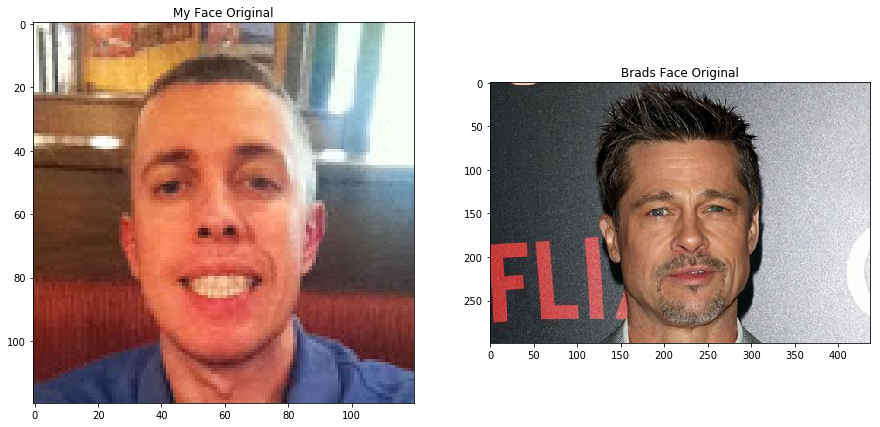

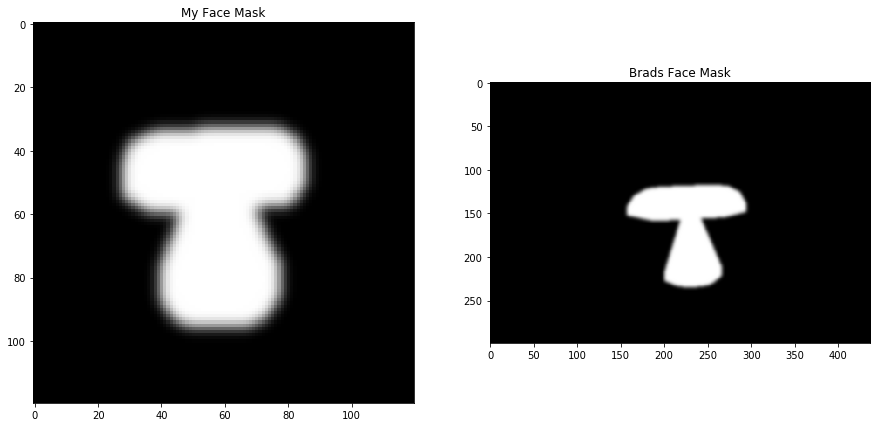

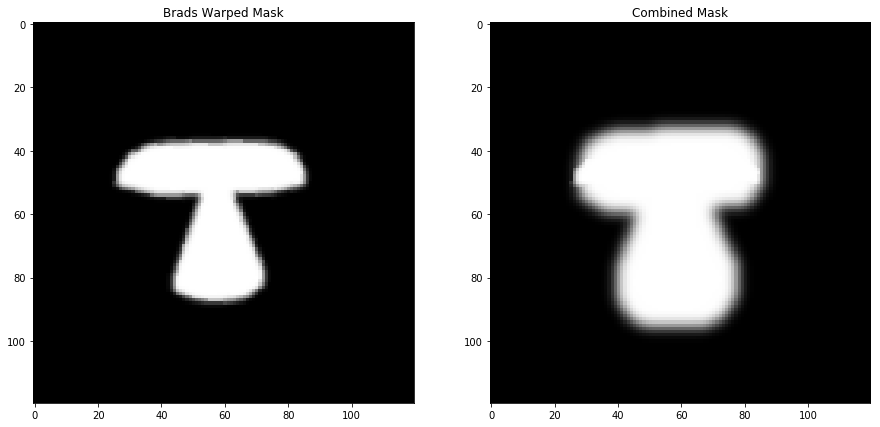

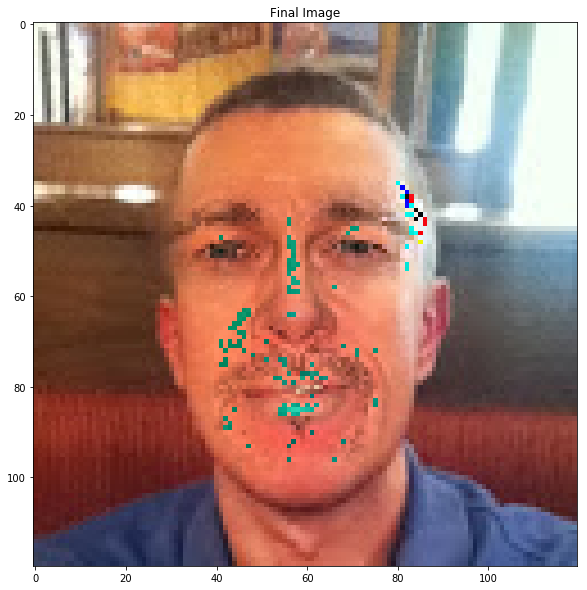

In [10]:
brad_face_image = cv2.imread('brad-face.jpg')
my_face_image = cv2.imread('my-face.jpg')

im1, landmarks1 = read_landmarks(my_face_image)
im2, landmarks2 = read_landmarks(brad_face_image)

# show the original images
plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)   
plt.title("My Face Original")
my_rgb = cv2.cvtColor(my_face_image, cv2.COLOR_BGR2RGB)
plt.imshow(my_rgb)
plt.subplot(1, 2, 2)
plt.title("Brads Face Original")
brad_rgb = cv2.cvtColor(brad_face_image, cv2.COLOR_BGR2RGB)
plt.imshow(brad_rgb)

# first generate the face mask for each image from the landmarks 
mask1 = get_face_mask(im1, landmarks1)
mask2 = get_face_mask(im2, landmarks2)

plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)   
plt.title("My Face Mask")
plt.imshow(mask1)
plt.subplot(1, 2, 2)
plt.title("Brads Face Mask")
plt.imshow(mask2)

# next get our transformation matrix and warp image 2 mask to fit image 1
M = transformation_from_points(landmarks1[ALIGN_POINTS],
                                           landmarks2[ALIGN_POINTS])
warped_mask2 = warp_im(mask2, M, im1.shape)

plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)
plt.title("Brads Warped Mask")
plt.imshow(warped_mask2)

# combine both masks to get the full facial coverage
combined_mask = np.max([mask1, warped_mask2], axis=0)

plt.subplot(1, 2, 2)
plt.title("Combined Mask")
plt.imshow(combined_mask)

# warp image 2 using our transformation matrix
warped_im2 = warp_im(im2, M, im1.shape)
# fix the colors for the warped image
warped_corrected_im2 = correct_colours(im1, warped_im2, landmarks1)

# output image is image 1 with the mask cut out + image 2 with the mask applied
output_im = im1 * (1.0 - combined_mask) + warped_corrected_im2 * combined_mask

plt.figure(figsize=(15,10))
plt.title("Final Image")
final = cv2.cvtColor(output_im.astype("uint8"), cv2.COLOR_BGR2RGB)
plt.imshow(final)